**Import Packages**

In [4]:
import pycaret
import pandas as pd
import numpy as np
import sqlalchemy
import mysql.connector

from pycaret import classification
from pycaret.classification import plot_model
from datetime import datetime
import importlib
import model.common

In [5]:
from static_data.load_static_data import *

**Load Data**

In [6]:
collect_data_Base_dir = 'collect_data'
df_game_matchup_total = pd.read_pickle(f'{collect_data_Base_dir}/df_game_matchup_total.pkl')
print(len(df_game_matchup_total))

326057


**Choose Columns**

In [7]:
importlib.reload(model.common)

<module 'model.common' from '/home/junlim/projects/mlb-props/model/common.py'>

In [8]:
feature_columns, target_column, model_file_name = model.common.features_1runs_recorded, model.common.target_1runs_recorded, model.common.model_1runs_file_name

In [9]:
train_data = df_game_matchup_total[(df_game_matchup_total.game_date > "2012-04-01") & (df_game_matchup_total.game_date < "2022-12-01")][feature_columns]
test_data = df_game_matchup_total[(df_game_matchup_total.game_date > "2022-12-01")][feature_columns]

**Build/Train Model**

In [14]:
import pycaret.classification

classification_setup = pycaret.classification.setup(
    data = train_data, target = target_column, train_size = .70, use_gpu = False, 
    categorical_features = ['game_venue'], ignore_features = model.common.ignore_features + ['batting_name', 'pitching_name'],
    #fix_imbalance=True, fix_imbalance_method='smote',
)

,Description,Value
0,Session id,6202
1,Target,batting_1runs_recorded
2,Target type,Binary
3,Original data shape,"(285090, 21)"
4,Transformed data shape,"(285090, 15)"
5,Transformed train set shape,"(199563, 15)"
6,Transformed test set shape,"(85527, 15)"
7,Ignore features,6
8,Numeric features,13
9,Categorical features,1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6576,0.6383,0.1369,0.5668,0.2206,0.0961,0.1362
1,0.6552,0.6433,0.1265,0.5560,0.2061,0.0863,0.1251
2,0.6552,0.6363,0.1361,0.5513,0.2183,0.0910,0.1278
3,0.6511,0.6357,0.1324,0.5280,0.2117,0.0814,0.1136
4,0.6555,0.6464,0.1303,0.5562,0.2111,0.0887,0.1272
5,0.6547,0.6404,0.1330,0.5498,0.2142,0.0885,0.1254
6,0.6573,0.6409,0.1327,0.5672,0.2151,0.0934,0.1341
7,0.6558,0.6440,0.1347,0.5561,0.2169,0.0915,0.1295
8,0.6558,0.6395,0.1358,0.5559,0.2183,0.0922,0.1300


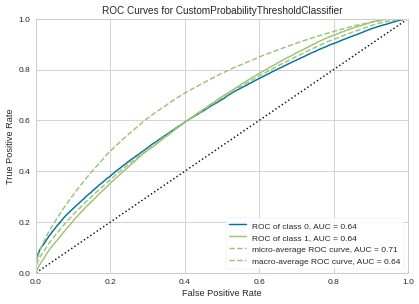

In [15]:
regression_model_lightgbm = classification_setup.create_model("lightgbm", probability_threshold = 0.50)
plot_model(regression_model_lightgbm, plot = 'auc', scale = 0.6)

In [16]:
regression_model_finalized_lightgbm = pycaret.classification.finalize_model(regression_model_lightgbm)

In [17]:
pycaret.classification.save_model(regression_model_finalized_lightgbm, model_file_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['pitching_gamesPlayed',
                                              'pitching_runs_per_game',
                                              'pitching_strikeOuts_per_game',
                                              'pitching_hits_per_game',
                                              'batting_gamesPlayed',
                                              'batting_runs_per_game',
                                              'batting_strikeOuts_per_game',
                                              'batting_hits_per_game',
                                              'batting_rbi',
                                              'pitching_cur_...
                                                       colsample_bytree=1.0,
                                                       importance_type='split

,Description,Value
0,Session id,2221
1,Target,batting_1runs_recorded
2,Target type,Binary
3,Original data shape,"(285090, 21)"
4,Transformed data shape,"(285090, 15)"
5,Transformed train set shape,"(199563, 15)"
6,Transformed test set shape,"(85527, 15)"
7,Ignore features,6
8,Numeric features,13
9,Categorical features,1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6513,0.6319,0.1263,0.5306,0.2040,0.0787,0.1121
1,0.6506,0.6282,0.1309,0.5250,0.2095,0.0795,0.1113
2,0.6537,0.6338,0.1354,0.5426,0.2167,0.0878,0.1228
3,0.6550,0.6349,0.1319,0.5525,0.2129,0.0886,0.1262
4,0.6522,0.6289,0.1360,0.5336,0.2167,0.0853,0.1184
5,0.6525,0.6278,0.1341,0.5359,0.2145,0.0849,0.1187
6,0.6549,0.6362,0.1357,0.5499,0.2177,0.0903,0.1268
7,0.6574,0.6341,0.1411,0.5637,0.2256,0.0979,0.1368
8,0.6530,0.6285,0.1283,0.5409,0.2074,0.0830,0.1184


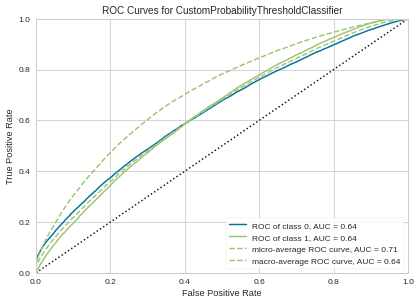

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6527,0.6422,0.1252,0.5397,0.2032,0.0807,0.1162
1,0.6537,0.6374,0.1289,0.5449,0.2085,0.0845,0.1208
2,0.6546,0.6421,0.1352,0.5482,0.2170,0.0895,0.1257
3,0.6557,0.6448,0.1262,0.5597,0.2059,0.0871,0.1268
4,0.6531,0.6332,0.1350,0.5393,0.2159,0.0865,0.1209
5,0.6539,0.6369,0.1314,0.5452,0.2118,0.0862,0.1222
6,0.6561,0.6429,0.1272,0.5623,0.2074,0.0885,0.1286
7,0.6589,0.6419,0.1375,0.5752,0.2220,0.0989,0.1408
8,0.6545,0.6357,0.1265,0.5512,0.2057,0.0849,0.1227


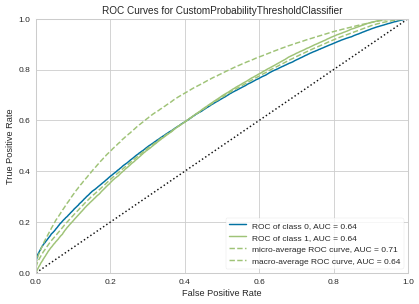

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6520,0.6392,0.1086,0.5409,0.1809,0.0709,0.1082
1,0.6536,0.6343,0.1132,0.5507,0.1877,0.0763,0.1153
2,0.6549,0.6396,0.1166,0.5587,0.1929,0.0806,0.1210
3,0.6557,0.6425,0.1115,0.5686,0.1864,0.0796,0.1226
4,0.6515,0.6310,0.1164,0.5348,0.1912,0.0741,0.1093
5,0.6551,0.6344,0.1141,0.5621,0.1898,0.0798,0.1212
6,0.6544,0.6416,0.1103,0.5592,0.1843,0.0766,0.1177
7,0.6580,0.6399,0.1177,0.5832,0.1959,0.0874,0.1330
8,0.6533,0.6325,0.1107,0.5499,0.1844,0.0746,0.1136


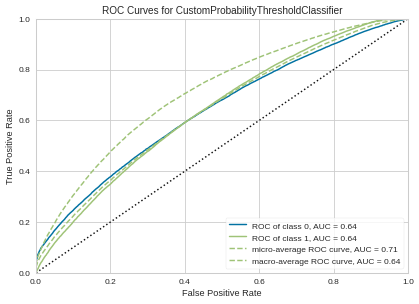

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6438,0.6262,0.2172,0.4926,0.3015,0.1084,0.1248
1,0.6443,0.6222,0.2065,0.4936,0.2912,0.1042,0.1218
2,0.6444,0.6279,0.2204,0.4943,0.3048,0.1108,0.1271
3,0.6470,0.6281,0.2206,0.5026,0.3067,0.1158,0.1334
4,0.6478,0.6241,0.2240,0.5051,0.3104,0.1188,0.1365
5,0.6405,0.6264,0.2075,0.4813,0.2900,0.0976,0.1131
6,0.6457,0.6254,0.2120,0.4985,0.2975,0.1094,0.1273
7,0.6475,0.6277,0.2221,0.5042,0.3083,0.1173,0.1351
8,0.6429,0.6233,0.2113,0.4893,0.2952,0.1039,0.1204


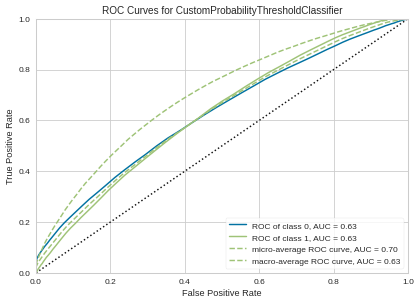

In [12]:
regression_model_ada, regression_model_lightgbm, regression_model_gbc, regression_model_rf = model.common.create_models(train_data, target_column)

**evaluate model**

`lightgbm` shows very good AUC of `0.97`, `rf` as well with `1.0` train AUC.

`rf` seemed like too overfit with 1.0 train AUC but its test precision as well is the best among others.

`ada` shows very low recall thus inpractical.


In [13]:
train_prediction_ada, train_prediction_gbc, train_prediction_lightgbm, train_prediction_rf = model.common.batch_predict_and_odds(train_data, [regression_model_ada, regression_model_gbc, regression_model_lightgbm, regression_model_rf])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.6544,0.6358,0.1412,0.5449,0.2243,0.0921,0.1270


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6565,0.6435,0.1161,0.5719,0.1930,0.0836,0.1269


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6631,0.6612,0.1420,0.6010,0.2297,0.1093,0.1561


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8935,0.9628,0.7652,0.9205,0.8357,0.7579,0.7650


In [14]:
model.common.evaluate_predictions([(train_prediction_ada, "ada"), (train_prediction_gbc, "gbc"), (train_prediction_lightgbm, "lightgbm"), (train_prediction_rf, "rf")], [0.6, 0.7, 0.75, 0.8], target_column)

model,0.6,0.7,0.75,0.8
ada,"(0, nan)","(0, nan)","(0, nan)","(0, nan)"
gbc,"(40, 0.65)","(10, 0.8)","(1, 1.0)","(1, 1.0)"
lightgbm,"(50, 0.7)","(16, 0.88)","(7, 1.0)","(2, 1.0)"
rf,"(296, 0.97)","(242, 0.99)","(179, 0.99)","(107, 1.0)"


**test prediction**

In [15]:
test_prediction_ada, test_prediction_gbc, test_prediction_lightgbm, test_prediction_rf = model.common.batch_predict_and_odds(test_data, [regression_model_ada, regression_model_gbc, regression_model_lightgbm, regression_model_rf])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.6423,0.6150,0.1540,0.5478,0.2404,0.0943,0.1269


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6449,0.6183,0.1326,0.5731,0.2154,0.0896,0.1300


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6421,0.6171,0.1442,0.5503,0.2285,0.0895,0.1237


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6374,0.6045,0.1936,0.5180,0.2819,0.1023,0.1245


In [16]:
model.common.evaluate_predictions([(test_prediction_ada, "ada"), (test_prediction_gbc, "gbc"), (test_prediction_lightgbm, "lightgbm"), (test_prediction_rf, "rf")], [0.6, 0.7, 0.75, 0.8, 0.85], target_column)

model,0.6,0.7,0.75,0.8,0.85
ada,"(0, nan)","(0, nan)","(0, nan)","(0, nan)","(0, nan)"
gbc,"(42, 0.64)","(7, 0.86)","(2, 0.5)","(0, nan)","(0, nan)"
lightgbm,"(36, 0.61)","(14, 0.71)","(5, 0.6)","(2, 1.0)","(0, nan)"
rf,"(42, 0.64)","(11, 0.55)","(1, 0.0)","(0, nan)","(0, nan)"


**Finalize Model**

In [17]:
# train over the whole dataset without validation split
regression_model_finalized_ada = pycaret.classification.finalize_model(regression_model_ada)
regression_model_finalized_gbc = pycaret.classification.finalize_model(regression_model_gbc)
regression_model_finalized_lightgbm = pycaret.classification.finalize_model(regression_model_lightgbm)
regression_model_finalized_rf = pycaret.classification.finalize_model(regression_model_rf)

In [18]:
test_finalized_prediction_ada, test_finalized_prediction_gbc, test_finalized_prediction_lightgbm, test_finalized_prediction_rf = model.common.batch_predict_and_odds(
    test_data, 
    [regression_model_finalized_ada, regression_model_finalized_gbc, regression_model_finalized_lightgbm, regression_model_finalized_rf])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.6422,0.6151,0.1474,0.5498,0.2325,0.0912,0.1249


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6461,0.6183,0.1397,0.5768,0.2250,0.0953,0.1357


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6404,0.6163,0.1455,0.5401,0.2293,0.0868,0.1186


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6340,0.6022,0.1935,0.5058,0.2799,0.0960,0.1159


In [19]:
model.common.evaluate_predictions([(test_finalized_prediction_ada, "ada"), (test_finalized_prediction_gbc, "gbc"), (test_finalized_prediction_lightgbm, "lightgbm"), (test_finalized_prediction_rf, "rf")], [0.6, 0.7, 0.75, 0.8, 0.85], target_column)

model,0.6,0.7,0.75,0.8,0.85
ada,"(0, nan)","(0, nan)","(0, nan)","(0, nan)","(0, nan)"
gbc,"(32, 0.66)","(8, 0.75)","(2, 1.0)","(0, nan)","(0, nan)"
lightgbm,"(39, 0.59)","(13, 0.85)","(4, 0.75)","(1, 1.0)","(0, nan)"
rf,"(35, 0.66)","(3, 0.67)","(1, 0.0)","(1, 0.0)","(0, nan)"


**Save Model**

In [20]:
pycaret.classification.save_model(regression_model_finalized_lightgbm, model_file_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['pitching_gamesPlayed',
                                              'pitching_runs_per_game',
                                              'pitching_strikeOuts_per_game',
                                              'pitching_hits_per_game',
                                              'batting_gamesPlayed',
                                              'batting_runs_per_game',
                                              'batting_strikeOuts_per_game',
                                              'batting_hits_per_game',
                                              'batting_rbi',
                                              'pitching_cur_...
                                                       colsample_bytree=1.0,
                                                       importance_type='split